In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
from scipy import signal

In [3]:
data_path_1 = Path("../datasets/1st_test")
files_1 = list(data_path_1.glob('*'))
print("num of files in set 1:", len(files_1))

num of files in set 1: 2156


In [4]:
data_path_2 = Path("../datasets/2nd_test")
files_2 = list(data_path_2.glob('*'))
print("num of files in set 2:", len(files_2))

num of files in set 2: 984


In [5]:
# Update path to match your folder structure
data_path_3 = Path("../datasets/3rd_test")
files_3 = sorted(list(data_path_3.glob('*')))

print("First file:", files_3[0].name)
print("Last file:", files_3[-1].name)
print("Total files in set 3:", len(files_3))

# Let's check if files are unique
unique_files = set(files_3)
print("\nUnique files:", len(unique_files))

First file: 2004.03.04.09.27.46
Last file: 2004.04.18.02.42.55
Total files in set 3: 6324

Unique files: 6324


In [6]:
# Cell 2: Key Analysis Functions from Phase 2
def analyze_frequency_bands(data, channel, sampling_rate=20000):
    """Analyze vibration data in three frequency bands"""
    channel_data = data[:, channel]
    
    bands = {
        'low': (20, 1000),    # Basic rotation band
        'mid': (1000, 3000),  # Early warning band
        'high': (3000, 5000)  # Damage zone band
    }
    
    filtered_signals = {}
    
    for band_name, (low_freq, high_freq) in bands.items():
        nyquist = sampling_rate / 2
        low_normalized = low_freq / nyquist
        high_normalized = high_freq / nyquist
        
        sos = signal.butter(4, [low_normalized, high_normalized], 
                          btype='bandpass', output='sos')
        
        filtered_signals[band_name] = signal.sosfilt(sos, channel_data)
    
    return filtered_signals

def analyze_signal_characteristics(filtered_bands):
    """Calculate key metrics for each frequency band"""
    analysis = {}
    
    for band_name, signal_data in filtered_bands.items():
        analysis[band_name] = {
            'RMS': np.sqrt(np.mean(signal_data**2)),
            'Peak': np.max(np.abs(signal_data)),
            'Crest': np.max(np.abs(signal_data)) / np.sqrt(np.mean(signal_data**2)),
            'Kurtosis': stats.kurtosis(signal_data)
        }
    
    return analysis

In [7]:
def extract_bearing_features(data, channels):
    """
    Extract all relevant features for a bearing from its channel(s)
    
    Args:
        data: Raw vibration data array
        channels: List of channel numbers for this bearing
    
    Returns:
        Dictionary of features
    """
    features = {}
    
    # For each channel of the bearing
    for channel in channels:
        # Get frequency bands
        bands = analyze_frequency_bands(data, channel)
        # Get characteristics for each band
        characteristics = analyze_signal_characteristics(bands)
        
        # Store features with channel identifier
        for band_name, metrics in characteristics.items():
            for metric_name, value in metrics.items():
                feature_name = f'Ch{channel+1}_{band_name}_{metric_name}'
                features[feature_name] = value
                
    return features

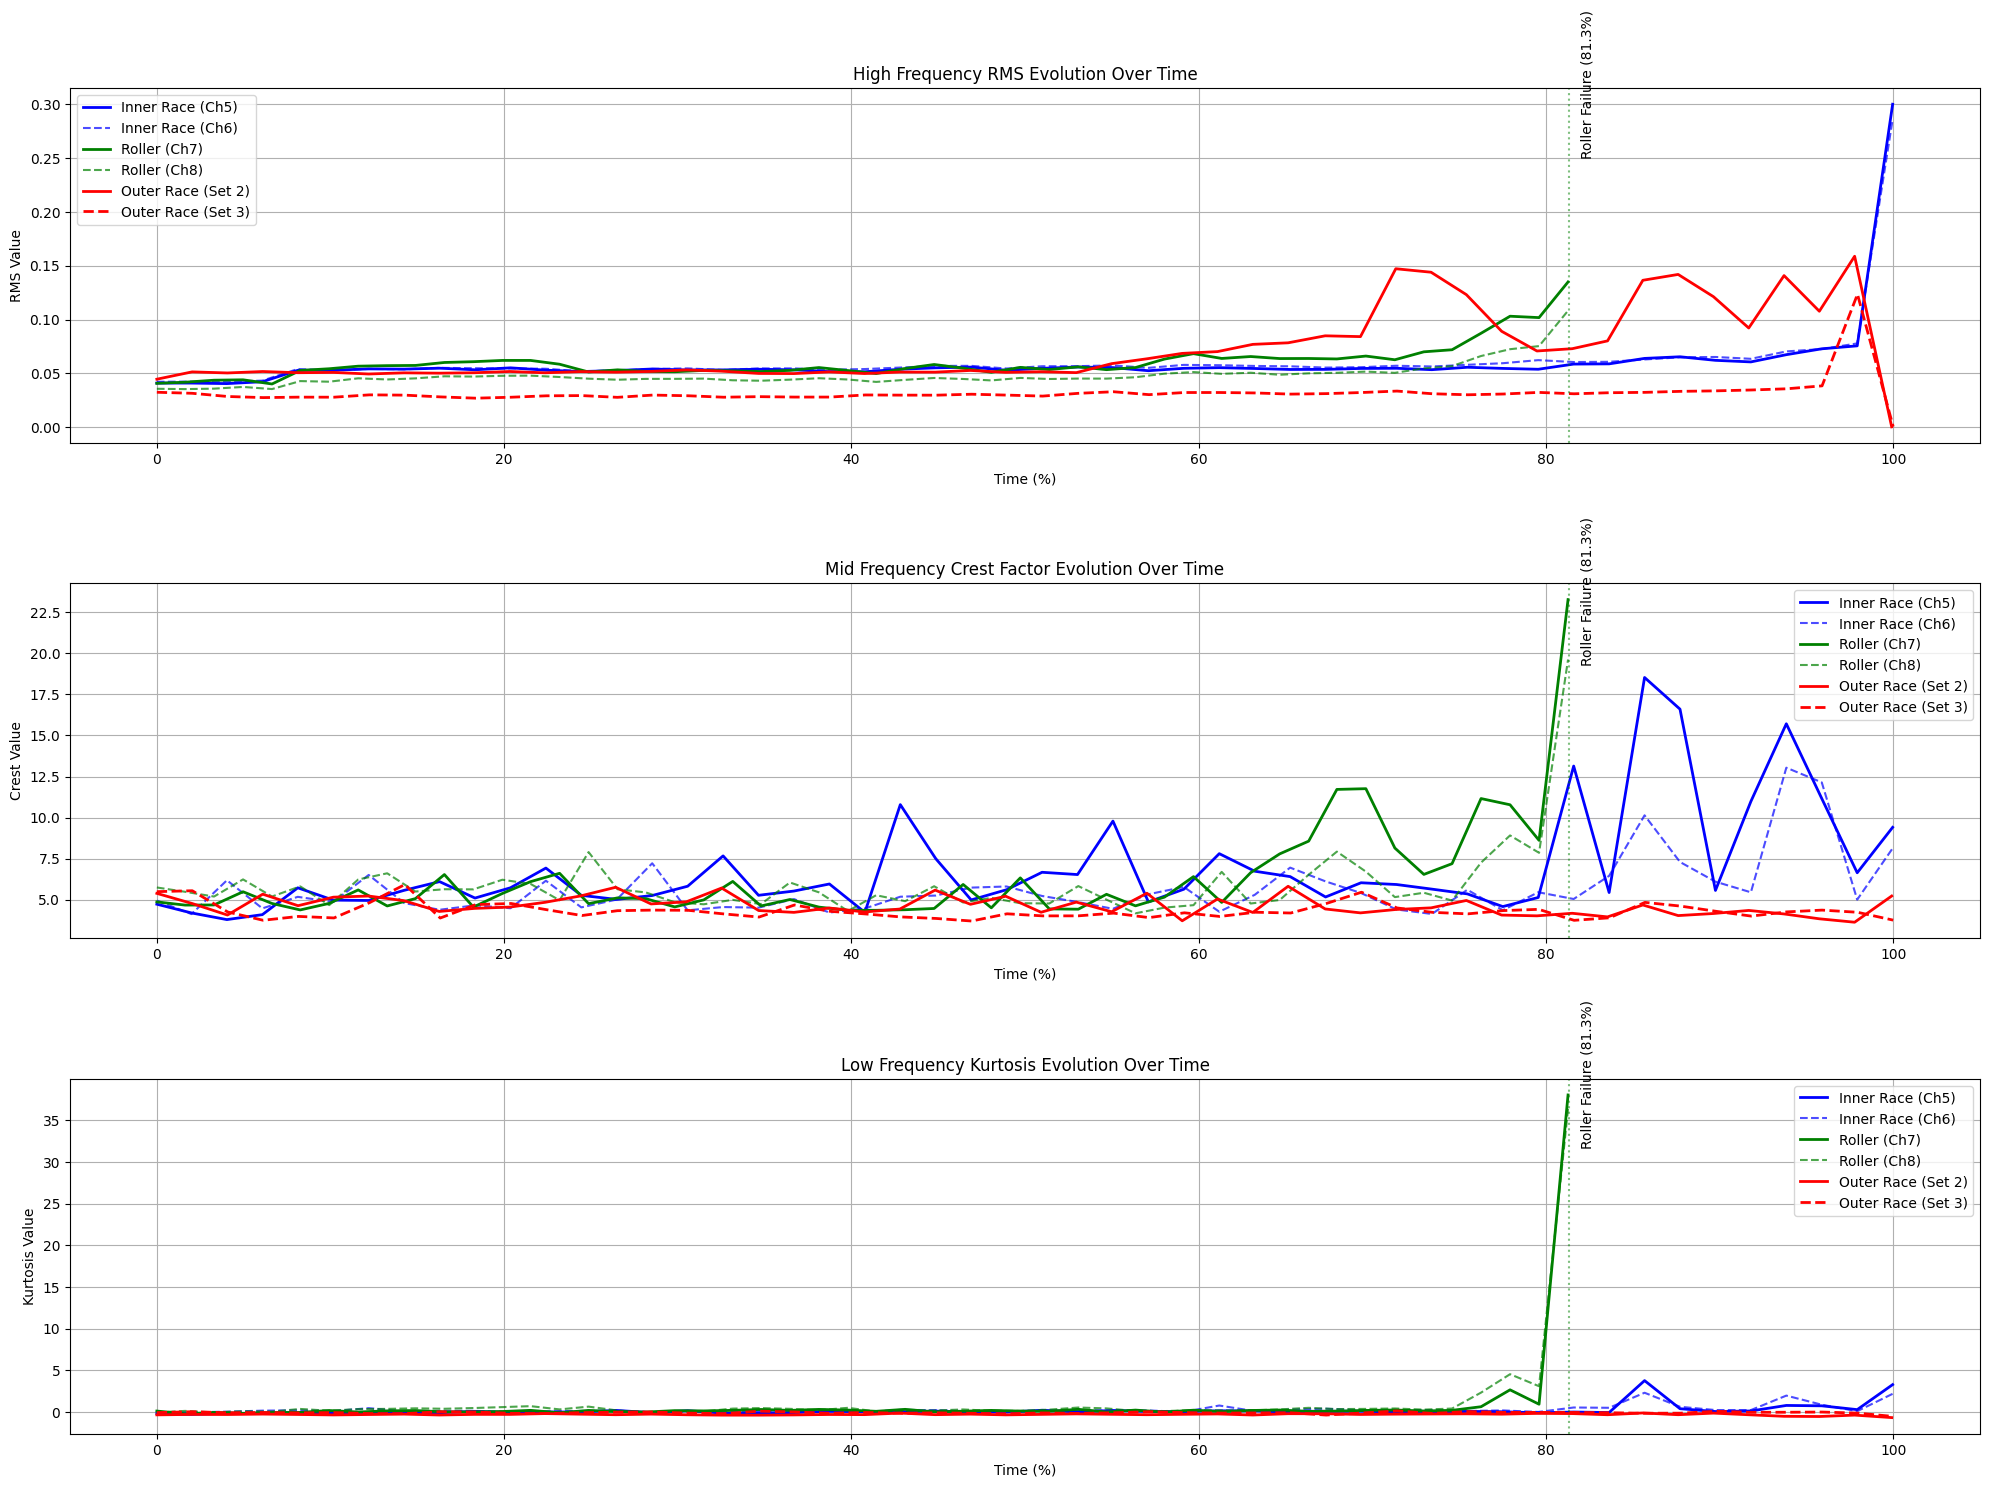

In [25]:
def plot_comprehensive_feature_evolution():
    """
    Plot all three metrics for all failure types, including both outer race failures
    """
    plt.figure(figsize=(20, 15))
    
    # Load data for all failure types
    # Set 1 - Inner Race (Bearing 3, Channels 5&6)
    files_1 = sorted(data_path_1.glob("*"))
    sample_indices = np.linspace(0, len(files_1)-1, 50, dtype=int)
    
    # Data collection for each bearing type
    features_data = {
        'inner_race': {'ch5': [], 'ch6': []},
        'roller': {'ch7': [], 'ch8': []},
        'outer_race_set2': {'ch1': []},
        'outer_race_set3': {'ch3': []}  # Added Set 3
    }
    
    # Collect Inner Race data
    for idx in sample_indices:
        data = np.loadtxt(files_1[idx])
        time_pct = (idx / len(files_1)) * 100
        
        # Channels 5&6 (Inner Race)
        for ch, ch_num in [(5,4), (6,5)]:
            features = extract_bearing_features(data, [ch_num])
            features['time_percentage'] = time_pct
            features_data['inner_race'][f'ch{ch}'].append(features)
    
    # Collect Roller data (up to 81.3%)
    roller_idx = int(len(files_1) * 0.813)
    roller_indices = np.linspace(0, roller_idx, 50, dtype=int)
    
    for idx in roller_indices:
        data = np.loadtxt(files_1[idx])
        time_pct = (idx / len(files_1)) * 100
        
        # Channels 7&8 (Roller)
        for ch, ch_num in [(7,6), (8,7)]:
            features = extract_bearing_features(data, [ch_num])
            features['time_percentage'] = time_pct
            features_data['roller'][f'ch{ch}'].append(features)
    
    # Collect Outer Race data - Set 2
    files_2 = sorted(data_path_2.glob("*"))
    sample_indices_2 = np.linspace(0, len(files_2)-1, 50, dtype=int)
    
    for idx in sample_indices_2:
        data = np.loadtxt(files_2[idx])
        time_pct = (idx / len(files_2)) * 100
        features = extract_bearing_features(data, [0])
        features['time_percentage'] = time_pct
        features_data['outer_race_set2']['ch1'].append(features)
    
    # Collect Outer Race data - Set 3 (Added)
    files_3 = sorted(data_path_3.glob("*"))
    sample_indices_3 = np.linspace(0, len(files_3)-1, 50, dtype=int)
    
    for idx in sample_indices_3:
        data = np.loadtxt(files_3[idx])
        time_pct = (idx / len(files_3)) * 100
        features = extract_bearing_features(data, [2])  # Channel 3 in Set 3
        features['time_percentage'] = time_pct
        features_data['outer_race_set3']['ch3'].append(features)
    
    # Plotting
    metrics = {
        'RMS': {'suffix': '_high_RMS', 'title': 'High Frequency RMS Evolution Over Time'},
        'Crest': {'suffix': '_mid_Crest', 'title': 'Mid Frequency Crest Factor Evolution Over Time'},
        'Kurtosis': {'suffix': '_low_Kurtosis', 'title': 'Low Frequency Kurtosis Evolution Over Time'}
    }
    
    for i, (metric, info) in enumerate(metrics.items(), 1):
        plt.subplot(3, 1, i)
        
        # Inner Race
        plt.plot([f['time_percentage'] for f in features_data['inner_race']['ch5']],
                [f[f'Ch5{info["suffix"]}'] for f in features_data['inner_race']['ch5']],
                'b-', label='Inner Race (Ch5)', linewidth=2)
        plt.plot([f['time_percentage'] for f in features_data['inner_race']['ch6']],
                [f[f'Ch6{info["suffix"]}'] for f in features_data['inner_race']['ch6']],
                'b--', label='Inner Race (Ch6)', alpha=0.7)
        
        # Roller
        plt.plot([f['time_percentage'] for f in features_data['roller']['ch7']],
                [f[f'Ch7{info["suffix"]}'] for f in features_data['roller']['ch7']],
                'g-', label='Roller (Ch7)', linewidth=2)
        plt.plot([f['time_percentage'] for f in features_data['roller']['ch8']],
                [f[f'Ch8{info["suffix"]}'] for f in features_data['roller']['ch8']],
                'g--', label='Roller (Ch8)', alpha=0.7)
        
        # Outer Race - Set 2
        plt.plot([f['time_percentage'] for f in features_data['outer_race_set2']['ch1']],
                [f[f'Ch1{info["suffix"]}'] for f in features_data['outer_race_set2']['ch1']],
                'r-', label='Outer Race (Set 2)', linewidth=2)
        
        # Outer Race - Set 3 (Added)
        plt.plot([f['time_percentage'] for f in features_data['outer_race_set3']['ch3']],
                [f[f'Ch3{info["suffix"]}'] for f in features_data['outer_race_set3']['ch3']],
                'r--', label='Outer Race (Set 3)', linewidth=2)
        
        plt.title(info['title'], fontsize=12)
        plt.xlabel('Time (%)')
        plt.ylabel(metric + ' Value')
        plt.legend()
        plt.grid(True)
        
        # Add Roller failure point marker
        plt.axvline(x=81.3, color='g', linestyle=':', alpha=0.5)
        plt.text(82, plt.ylim()[1]*0.8, 'Roller Failure (81.3%)', rotation=90)
    
    plt.tight_layout()
    plt.show()

plot_comprehensive_feature_evolution()

In [44]:
def calculate_degradation_features(time_series, window_size=5):
    """
    Calculate progressive degradation features from a time series of measurements
    
    Parameters:
        time_series: array of values over time
        window_size: size of window for calculating rates (default 5)
    
    Returns:
        Dictionary of degradation features
    """
    # Convert to numpy array if it isn't already
    
    data = np.array(time_series)
    
    # Calculate baseline (average of first 20% of data)
    baseline = np.mean(data[:int(len(data)*0.2)])
    
    # Calculate features
    features = {
        # Baseline ratios at different stages
        
        'mid_to_baseline_ratio': np.mean(data[int(len(data)*0.4):int(len(data)*0.6)]) / baseline,
        'late_to_baseline_ratio': np.mean(data[int(len(data)*0.8):]) / baseline,
        
        # Rate of change in different regions
        'early_rate': np.mean(np.diff(data[:int(len(data)*0.3)])),
        'mid_rate': np.mean(np.diff(data[int(len(data)*0.3):int(len(data)*0.7)])),
        'late_rate': np.mean(np.diff(data[int(len(data)*0.7):])),
        
        # Stability measures
        'early_stability': np.std(data[:int(len(data)*0.3)]),
        'mid_stability': np.std(data[int(len(data)*0.3):int(len(data)*0.7)]),
        'late_stability': np.std(data[int(len(data)*0.7):])
    }
    
    return features


In [59]:
def test_all_failure_types():
    """
    Calculate degradation features for all failure types, all relevant channels.
    Now properly collecting all features across all frequency bands and metrics.
    """
    print("\n=== Complete Degradation Features Analysis Across Failure Types ===\n")
    
    files_1 = sorted(data_path_1.glob("*"))
    files_2 = sorted(data_path_2.glob("*"))
    files_3 = sorted(data_path_3.glob("*"))
    
    # Dictionary to store all feature time series
    feature_series = {
        'Inner Race': {
            'channels': [4, 5],  # channels 5&6
            'files': files_1,
            'data': {}
        },
        'Roller': {
            'channels': [6, 7],  # channels 7&8
            'files': files_1,
            'end_idx': int(len(files_1) * 0.813),  # Known failure point
            'data': {}
        },
        'Outer Race Set2': {
            'channels': [0],  # channel 1
            'files': files_2,
            'data': {}
        },
        'Outer Race Set3': {
            'channels': [2],  # channel 3
            'files': files_3,
            'data': {}
        }
    }
    
    # Process each failure type
    for failure_type, config in feature_series.items():
        
        sampling_percentage = 0.05  # percentage %
        min_samples = 20           

        num_samples = max(min_samples, int(len(config['files']) * sampling_percentage))
        print(num_samples)

        if failure_type == 'Roller':
            end_point = config['end_idx']
        else:
            end_point = len(config['files'])-1

        sample_indices = np.linspace(0, end_point, num_samples, dtype=int)

        
        print(sample_indices)

            
        # Initialize feature storage for each channel
        for channel in config['channels']:
            channel_key = f'Ch{channel+1}'
            config['data'][channel_key] = {
                band: {metric: [] for metric in ['RMS', 'Peak', 'Crest', 'Kurtosis']}
                for band in ['low', 'mid', 'high']
            }
        
        # Collect features over time
        for idx in sample_indices:
            data = np.loadtxt(config['files'][idx])
            
            # Process each channel
            for channel in config['channels']:
                features = extract_bearing_features(data, [channel])
                channel_key = f'Ch{channel+1}'
                
                # Store all features
                for band in ['low', 'mid', 'high']:
                    for metric in ['RMS', 'Peak', 'Crest', 'Kurtosis']:
                        feature_name = f'{channel_key}_{band}_{metric}'
                        config['data'][channel_key][band][metric].append(features[feature_name])
        
        # Calculate degradation features for each series
        print(f"\n{failure_type} Analysis:")
        print("=" * 50)
        
        for channel in config['channels']:
            channel_key = f'Ch{channel+1}'
            print(f"\n{channel_key} Features:")
            print("-" * 30)
            
            for band in ['low', 'mid', 'high']:
                print(f"\n{band.upper()} Band:")
                for metric in ['RMS', 'Peak', 'Crest', 'Kurtosis']:
                    values = config['data'][channel_key][band][metric]
                    features = calculate_degradation_features(values)
                    
                    print(f"\n{metric}:")
                    print(f"  Ratios - Mid/Base: {features['mid_to_baseline_ratio']:.4f}, "
                          f"Late/Base: {features['late_to_baseline_ratio']:.4f}")
                    print(f"  Rates - Early: {features['early_rate']:.4f}, "
                          f"Mid: {features['mid_rate']:.4f}, Late: {features['late_rate']:.4f}")
                    print(f"  Stability - Early: {features['early_stability']:.4f}, "
                          f"Mid: {features['mid_stability']:.4f}, Late: {features['late_stability']:.4f}")
    
    return feature_series  # Return all data for potential further analysis

# Run the enhanced analysis
all_features = test_all_failure_types()


=== Complete Degradation Features Analysis Across Failure Types ===

107
[   0   20   40   60   81  101  121  142  162  182  203  223  243  264
  284  304  325  345  365  386  406  426  447  467  487  508  528  548
  569  589  609  630  650  670  691  711  731  752  772  792  813  833
  853  874  894  914  935  955  975  996 1016 1036 1057 1077 1097 1118
 1138 1158 1179 1199 1219 1240 1260 1280 1301 1321 1341 1362 1382 1402
 1423 1443 1463 1484 1504 1524 1545 1565 1585 1606 1626 1646 1667 1687
 1707 1728 1748 1768 1789 1809 1829 1850 1870 1890 1911 1931 1951 1972
 1992 2012 2033 2053 2073 2094 2114 2134 2155]

Inner Race Analysis:

Ch5 Features:
------------------------------

LOW Band:

RMS:
  Ratios - Mid/Base: 1.0483, Late/Base: 1.2330
  Rates - Early: 0.0001, Mid: -0.0000, Late: 0.0025
  Stability - Early: 0.0017, Mid: 0.0007, Late: 0.0137

Peak:
  Ratios - Mid/Base: 1.1002, Late/Base: 2.2358
  Rates - Early: 0.0017, Mid: 0.0006, Late: 0.0252
  Stability - Early: 0.0169, Mid: 0.01

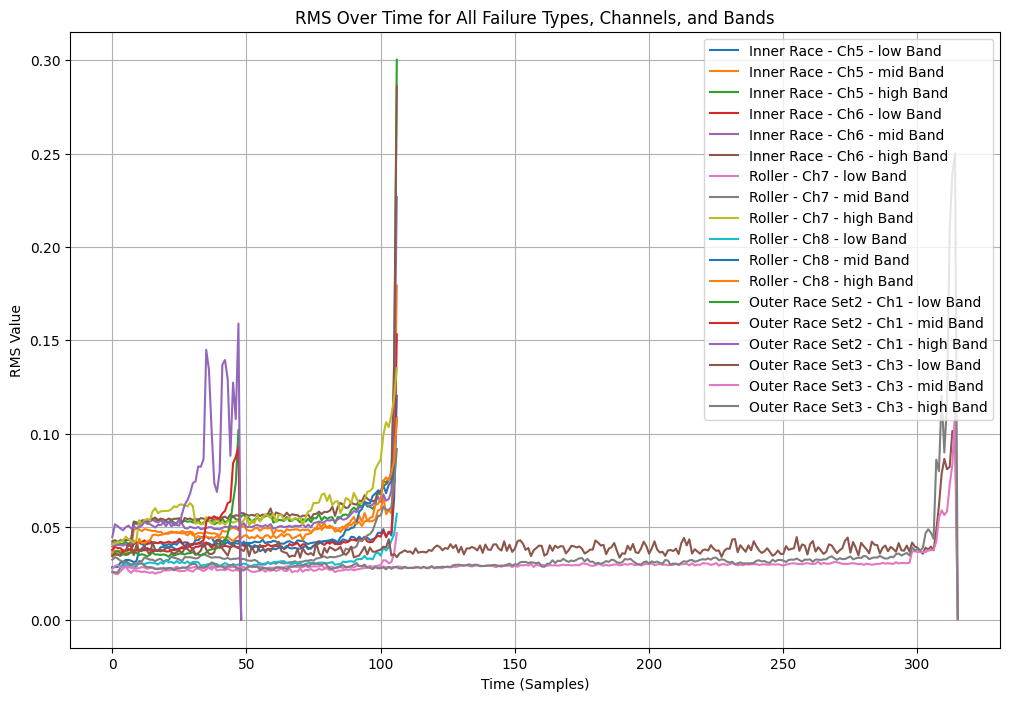

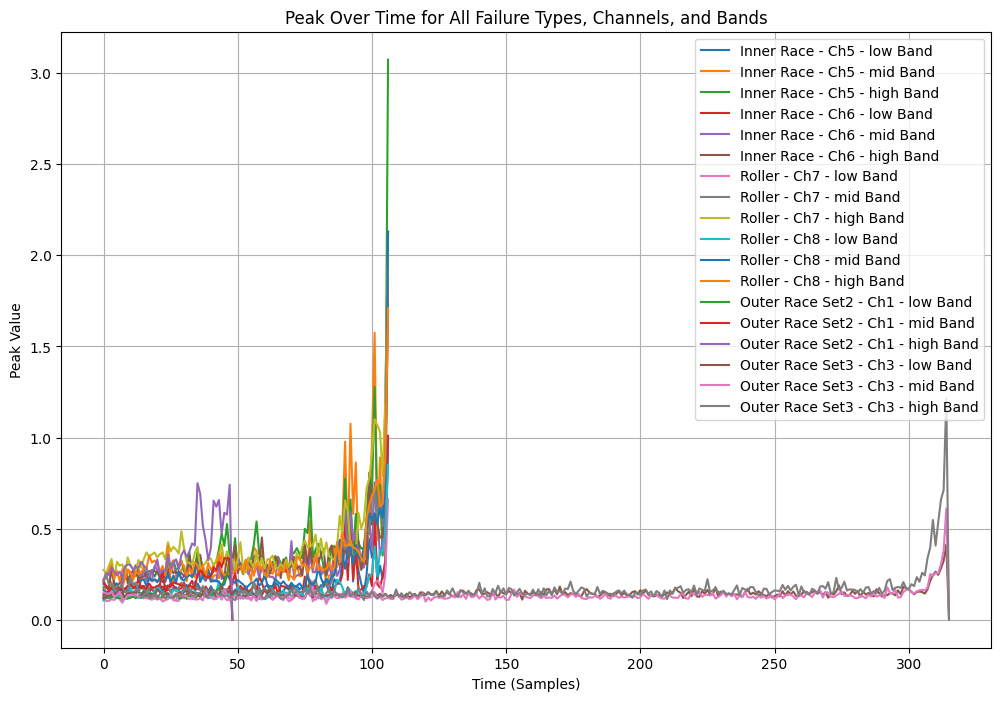

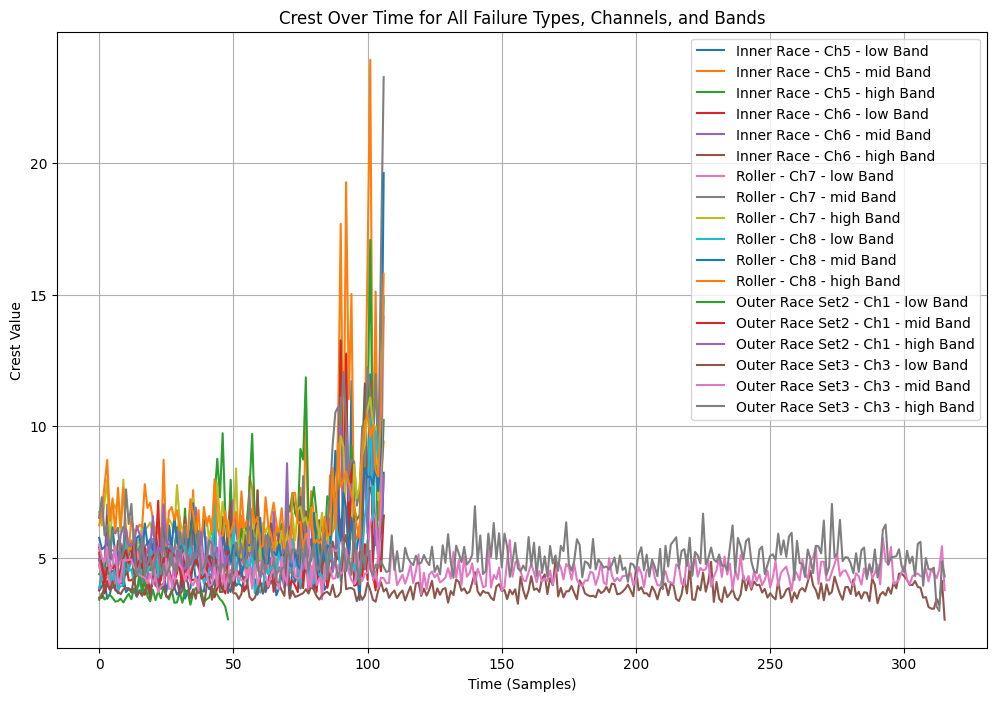

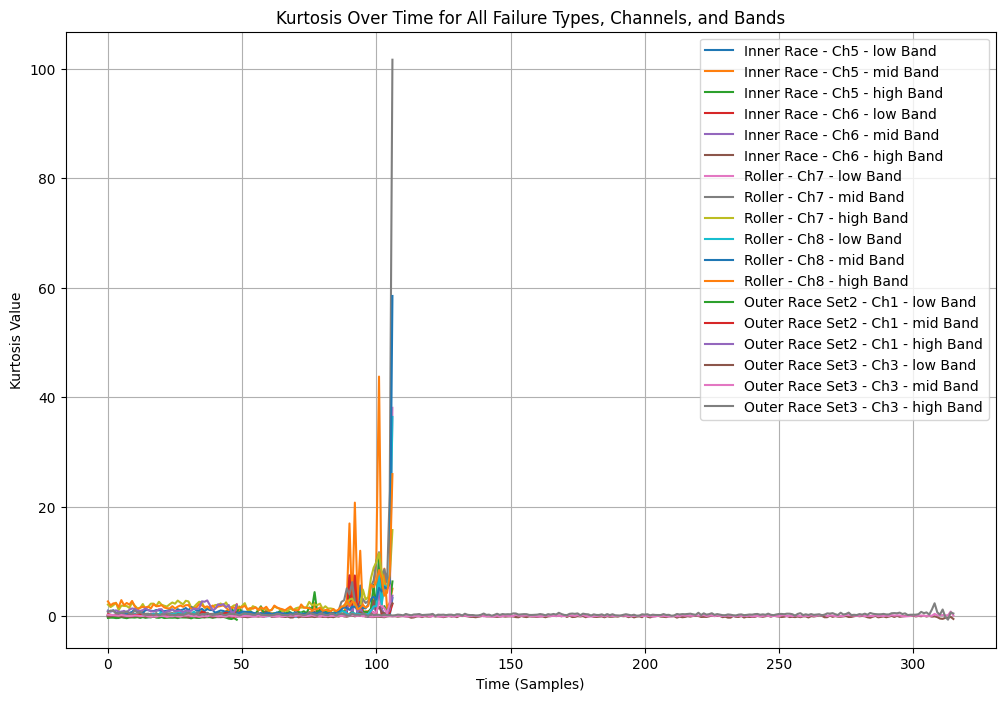

In [60]:

def plot_feature_over_time(feature_series, metric):
    """
    Generate and plot the specified metric (RMS, Peak, Crest, Kurtosis) for all failure types,
    channels, and frequency bands over time.
    """
    plt.figure(figsize=(12, 8))
    
    for failure_type, config in feature_series.items():
        for channel in config['channels']:
            channel_key = f'Ch{channel+1}'
            for band in ['low', 'mid', 'high']:
                # Get the values for the current metric
                values = config['data'][channel_key][band][metric]
                
                # Generate plot for each failure type, channel, frequency band
                plt.plot(values, label=f'{failure_type} - {channel_key} - {band} Band')
    
    plt.title(f'{metric} Over Time for All Failure Types, Channels, and Bands')
    plt.xlabel('Time (Samples)')
    plt.ylabel(f'{metric} Value')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Example usage to plot each metric
metrics = ['RMS', 'Peak', 'Crest', 'Kurtosis']
for metric in metrics:
    plot_feature_over_time(all_features, metric)


In [54]:
def extract_all_features(data, channel):
    """
    Extract complete feature set incorporating all bands and metrics
    """
    # Get frequency features
    freq_bands = analyze_frequency_bands(data, channel)
    freq_chars = analyze_signal_characteristics(freq_bands)
    
    features = {}
    
    # Add direct features
    for band in ['low', 'mid', 'high']:
        features[f'{band}_rms'] = freq_chars[band]['RMS']
        features[f'{band}_peak'] = freq_chars[band]['Peak']
        features[f'{band}_crest'] = freq_chars[band]['Crest']
        features[f'{band}_kurtosis'] = freq_chars[band]['Kurtosis']
    
    # Get raw time series for degradation
    time_series = data[:, channel]  # This gives us the actual time series!
    
    # Calculate degradation on the raw signal
    deg_features = calculate_degradation_features(time_series)  # Pass the full time series
    
    # Add degradation features with proper prefixes
    for key, value in deg_features.items():
        features[f'degradation_{key}'] = value
            
    return features

Set 1 (Inner Race): 107 samples from 2156 files
Set 1 (Roller): 87 samples from 1752 files (0.813 cutoff)
Set 2 (Outer Race): 49 samples from 984 files
Set 3 (Outer Race): 316 samples from 6324 files


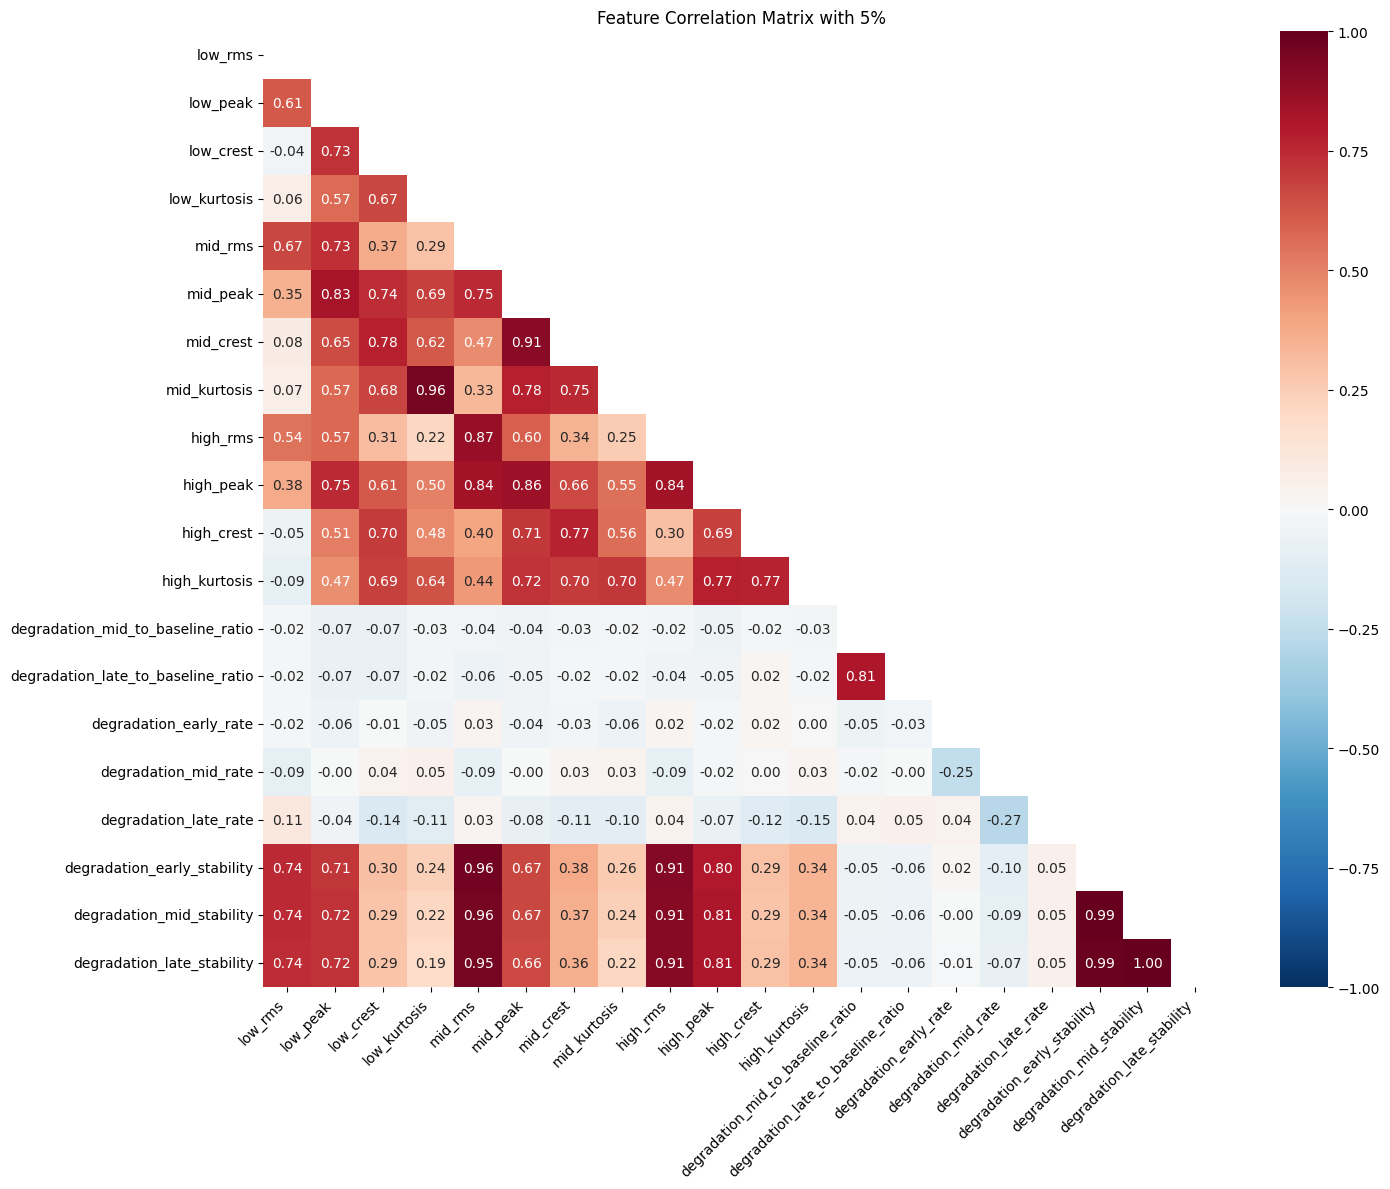


Top 10 strongest correlations:
degradation_mid_stability - degradation_late_stability: 0.995
degradation_early_stability - degradation_mid_stability: 0.994
degradation_early_stability - degradation_late_stability: 0.987
mid_rms              - degradation_early_stability: 0.962
mid_rms              - degradation_mid_stability: 0.959
low_kurtosis         - mid_kurtosis        : 0.955
mid_rms              - degradation_late_stability: 0.955
high_rms             - degradation_early_stability: 0.914
high_rms             - degradation_mid_stability: 0.910
high_rms             - degradation_late_stability: 0.907


In [56]:
def create_correlation_matrix():
    """
    Create and analyze correlation matrix for all features
    """
    feature_data = []
    sampling_percentage = 0.05
    min_samples = 20
    
    # Set 1 files
    files_1 = sorted(data_path_1.glob("*"))
    # Set 2 files
    files_2 = sorted(data_path_2.glob("*"))
    # Set 3 files
    files_3 = sorted(data_path_3.glob("*"))
    
    # Inner Race (Set 1, Bearing 3, Channel 5)
    num_samples_1 = max(min_samples, int(len(files_1) * sampling_percentage))
    sample_indices = np.linspace(0, len(files_1)-1, num_samples_1, dtype=int)
    for idx in sample_indices:
        data = np.loadtxt(files_1[idx])
        features = extract_all_features(data, 4)  # Channel 5
        if features is not None:
            feature_data.append(features)
    
    # Roller (Set 1, Bearing 4, Channel 7)
    roller_end_idx = int(len(files_1) * 0.813)  # Known failure point
    num_samples_roller = max(min_samples, int(roller_end_idx * sampling_percentage))
    roller_indices = np.linspace(0, roller_end_idx, num_samples_roller, dtype=int)
    for idx in roller_indices:
        data = np.loadtxt(files_1[idx])
        features = extract_all_features(data, 6)  # Channel 7
        if features is not None:
            feature_data.append(features)
    
    # Outer Race Set 2 (Bearing 1, Channel 1)
    num_samples_2 = max(min_samples, int(len(files_2) * sampling_percentage))
    sample_indices_2 = np.linspace(0, len(files_2)-1, num_samples_2, dtype=int)
    for idx in sample_indices_2:
        data = np.loadtxt(files_2[idx])
        features = extract_all_features(data, 0)  # Channel 1
        if features is not None:
            feature_data.append(features)
            
    # Outer Race Set 3 (Bearing 3, Channel 3)
    num_samples_3 = max(min_samples, int(len(files_3) * sampling_percentage))
    sample_indices_3 = np.linspace(0, len(files_3)-1, num_samples_3, dtype=int)
    for idx in sample_indices_3:
        data = np.loadtxt(files_3[idx])
        features = extract_all_features(data, 2)  # Channel 3 (index 2)
        if features is not None:
            feature_data.append(features)
    
    # Print sampling information
    print(f"Set 1 (Inner Race): {num_samples_1} samples from {len(files_1)} files")
    print(f"Set 1 (Roller): {num_samples_roller} samples from {roller_end_idx} files (0.813 cutoff)")
    print(f"Set 2 (Outer Race): {num_samples_2} samples from {len(files_2)} files")
    print(f"Set 3 (Outer Race): {num_samples_3} samples from {len(files_3)} files")
    
    # Rest of your correlation matrix code stays the same
    df = pd.DataFrame(feature_data)
    df = df.dropna(axis=1, how='all')
    correlation_matrix = df.corr()
    
    plt.figure(figsize=(15, 12))
    mask = np.triu(np.ones_like(correlation_matrix), k=0)
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r',
                center=0,
                fmt='.2f',
                square=True,
                vmin=-1, 
                vmax=1)
    
    plt.title('Feature Correlation Matrix with 5%')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    correlations = []
    for i in range(len(df.columns)):
        for j in range(i+1, len(df.columns)):
            corr = correlation_matrix.iloc[i, j]
            if not np.isnan(corr):
                correlations.append((df.columns[i], df.columns[j], abs(corr)))
    
    correlations.sort(key=lambda x: x[2], reverse=True)
    print("\nTop 10 strongest correlations:")
    for feat1, feat2, corr in correlations[:10]:
        print(f"{feat1:20} - {feat2:20}: {corr:.3f}")
    
    return df, correlation_matrix

# Run the analysis
df, corr_matrix = create_correlation_matrix()

In [58]:
def create_feature_dataset():
    """
    Create complete dataset with all bearings and their features for ML model
    """
    feature_data = []
    sampling_percentage = 0.05
    min_samples = 20
    
    # Load all datasets
    files_1 = sorted(data_path_1.glob("*"))
    files_2 = sorted(data_path_2.glob("*"))
    files_3 = sorted(data_path_3.glob("*"))
    
    # Inner Race (Set 1, Bearing 3, Channels 5&6)
    num_samples_1 = max(min_samples, int(len(files_1) * sampling_percentage))
    sample_indices = np.linspace(0, len(files_1)-1, num_samples_1, dtype=int)
    for idx in sample_indices:
        data = np.loadtxt(files_1[idx])
        # Process both channels
        for channel in [4, 5]:  # Channels 5&6
            features = extract_all_features(data, channel)
            if features is not None:
                features['failure_type'] = 'inner_race'
                features['channel'] = f'Ch{channel+1}'
                features['sample_number'] = idx
                feature_data.append(features)
    
    # Roller (Set 1, Bearing 4, Channels 7&8)
    roller_end_idx = int(len(files_1) * 0.813)
    num_samples_roller = max(min_samples, int(roller_end_idx * sampling_percentage))
    roller_indices = np.linspace(0, roller_end_idx, num_samples_roller, dtype=int)
    for idx in roller_indices:
        data = np.loadtxt(files_1[idx])
        # Process both channels
        for channel in [6, 7]:  # Channels 7&8
            features = extract_all_features(data, channel)
            if features is not None:
                features['failure_type'] = 'roller'
                features['channel'] = f'Ch{channel+1}'
                features['sample_number'] = idx
                feature_data.append(features)
    
    # Outer Race Set 2 (Bearing 1, Channel 1)
    num_samples_2 = max(min_samples, int(len(files_2) * sampling_percentage))
    sample_indices_2 = np.linspace(0, len(files_2)-1, num_samples_2, dtype=int)
    for idx in sample_indices_2:
        data = np.loadtxt(files_2[idx])
        features = extract_all_features(data, 0)  # Channel 1
        if features is not None:
            features['failure_type'] = 'outer_race_set2'
            features['channel'] = 'Ch1'
            features['sample_number'] = idx
            feature_data.append(features)
    
    # Outer Race Set 3 (Bearing 3, Channel 3)
    num_samples_3 = max(min_samples, int(len(files_3) * sampling_percentage))
    sample_indices_3 = np.linspace(0, len(files_3)-1, num_samples_3, dtype=int)
    for idx in sample_indices_3:
        data = np.loadtxt(files_3[idx])
        features = extract_all_features(data, 2)  # Channel 3
        if features is not None:
            features['failure_type'] = 'outer_race_set3'
            features['channel'] = 'Ch3'
            features['sample_number'] = idx
            feature_data.append(features)
    
    # Create DataFrame
    df = pd.DataFrame(feature_data)
    
    # Print dataset information
    print(f"Total samples: {len(df)}")
    print("\nSamples per failure type:")
    print(df['failure_type'].value_counts())
    print("\nSamples per channel:")
    print(df['channel'].value_counts())
    print("\nDataset columns:")
    print(df.columns)
    
    # Save to CSV
    output_file = "bearing_features.csv"
    df.to_csv(output_file, index=False)
    print(f"\nDataset saved to {output_file}")
    
    return df

# Create and save dataset
feature_df = create_feature_dataset()

Total samples: 753

Samples per failure type:
failure_type
outer_race_set3    316
inner_race         214
roller             174
outer_race_set2     49
Name: count, dtype: int64

Samples per channel:
channel
Ch3    316
Ch5    107
Ch6    107
Ch7     87
Ch8     87
Ch1     49
Name: count, dtype: int64

Dataset columns:
Index(['low_rms', 'low_peak', 'low_crest', 'low_kurtosis', 'mid_rms',
       'mid_peak', 'mid_crest', 'mid_kurtosis', 'high_rms', 'high_peak',
       'high_crest', 'high_kurtosis', 'degradation_mid_to_baseline_ratio',
       'degradation_late_to_baseline_ratio', 'degradation_early_rate',
       'degradation_mid_rate', 'degradation_late_rate',
       'degradation_early_stability', 'degradation_mid_stability',
       'degradation_late_stability', 'failure_type', 'channel',
       'sample_number'],
      dtype='object')

Dataset saved to bearing_features.csv
